In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy.ndimage as ndimage
from tqdm import tqdm_notebook
import community as cm
import networkx as nx
from collections import Counter
import pickle
from natsort import natsorted
from scipy.optimize import curve_fit

In [4]:
def fractal_model(generation,m,x,e):
	"""
	Returns the fractal model introduced by
	Song, Havlin, Makse in Nature Physics 2, 275.
	generation = number of generations
	m = number of offspring per node
	x = number of connections between offsprings
	e = probability that hubs stay connected
	1-e = probability that x offsprings connect.
	If e=1 we are in MODE 1 (pure small-world).
	If e=0 we are in MODE 2 (pure fractal).
	"""
	G=nx.Graph()
	G.add_edge(0,1) #This is the seed for the network (generation 0)
	node_index = 2
	for n in range(1,generation+1):
		all_links = list(G.edges())
		while all_links:
			link = all_links.pop()
			new_nodes_a = range(node_index,node_index + m)
			#random.shuffle(new_nodes_a)
			node_index += m
			new_nodes_b = range(node_index,node_index + m)
			#random.shuffle(new_nodes_b)
			node_index += m
			G.add_edges_from([(link[0],node) for node in new_nodes_a])
			G.add_edges_from([(link[1],node) for node in new_nodes_b])
			repulsive_links = list(zip(new_nodes_a,new_nodes_b))
			G.add_edges_from([repulsive_links.pop() for i in range(x-1)])
			if np.random.random() > e:
				G.remove_edge(link[0], link[1])
				new_edge = repulsive_links.pop()
				G.add_edge(new_edge[0], new_edge[1])
	return G

1038 1296


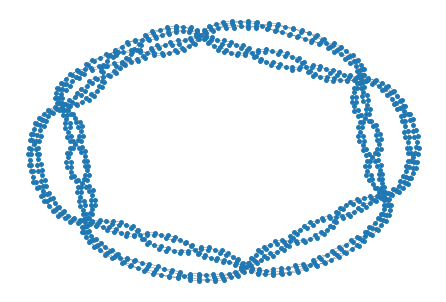

In [13]:
# g = nx.read_graphml('time_graphs/0/1250.graphml')
g = fractal_model(4,2,2,0)
# g = nx.connected_watts_strogatz_graph(1500, 5, 0.15)
# g = nx.read_edgelist('real_graphs/email.txt', data=False)
layout = nx.kamada_kawai_layout(g)

communities = nx.algorithms.community.centrality.girvan_newman(g)
print(g.number_of_nodes(), g.number_of_edges())
nx.draw(g, pos=layout, node_size=15, width=0.25)

In [14]:
levels = []
for com in tqdm_notebook(communities):
    levels.append(com)

In [15]:
cluster_nodes = []
for i in "abcdefghijklmnopqrstuvwxyz":
    for j in "abcdefghijklmnopqrstuvwxyz":
        for k in "abcdefghijklmnopqrstuvwxyz":
            cluster_nodes.append(i + j + k)
            
dendro = nx.DiGraph()
dendro.add_node(tuple(g.nodes))

In [16]:
levels = [[tuple(sorted(x)) for x in sub] for sub in levels]
dendro.add_nodes_from(levels[0])
dendro.add_edges_from([(tuple(g.nodes), l) for l in levels[0]])

In [17]:
for i in range(len(levels) - 1):
    dendro.add_nodes_from(levels[i])
    split = list(set(levels[i]) - set(levels[i]).intersection(set(levels[i+1])))
    children = list(set(levels[i+1]) - set(levels[i]).intersection(set(levels[i+1])))
    dendro.add_edges_from([(split[0], c) for c in children])

2075 2074
1038


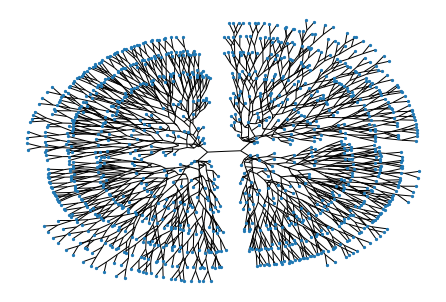

In [19]:
remap_dict = {}
counter = 0
draws = []
colors = []
print(dendro.number_of_nodes(), dendro.number_of_edges())
for n in dendro.nodes:
    if len(n) > 1:
        remap_dict[n] = cluster_nodes[counter]
        counter += 1
    else:
        remap_dict[n] = n[0]
        draws.append(n[0])
        
remapped = nx.relabel_nodes(dendro, remap_dict)
print(len(draws))

nx.draw_kamada_kawai(nx.Graph(remapped), node_size=5, nodelist=draws)
plt.savefig('fractal_dendro.png', dpi=2160)

[1.0337989]
0.9989291949755986


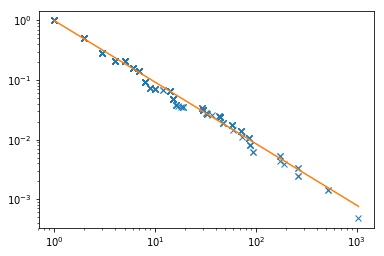

In [32]:
flattened = [x for y in levels for x in y]

flattened = list(set(flattened))

sizes = [len(x) for x in flattened]
sizes.append(g.number_of_nodes())

xs = sorted(sizes)
ys = [len([s for s in sizes if s >= m]) for m in xs]
ys = [y / len(sizes) for y in ys]

def hausdorff(lb, db):
    return lb**-db

popt = curve_fit(hausdorff, xs, ys)[0]
print(popt)

plt.xscale('log')
plt.yscale('log')
plt.plot(xs, ys, 'x')
curve_vals = [hausdorff(x, popt) for x in xs]
plt.plot(xs, curve_vals)

y_fits = ys
x_fits = xs

y_fit = hausdorff(x_fits, *popt)

ss_res = np.sum((y_fits - y_fit) ** 2)

# total sum of squares
ss_tot = np.sum((y_fits - np.mean(y_fits)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

In [21]:
root = 'aaa'
nx.set_node_attributes(remapped, 0, 'hs')
            
ratios = []
    
def compute_hs(node):
    if not list(remapped.neighbors(node)):
        ratios.append(1)
        return 1
    children = list(remapped.neighbors(node))
    if len(children) > 2:
        print(node, children)
        return
    l = children[0]
    r = children[1]
    
    if remapped.node[l]['hs'] == 0:
        remapped.node[l]['hs'] = compute_hs(l)
    if remapped.node[r]['hs'] == 0:
        remapped.node[r]['hs'] = compute_hs(r)
    
    if remapped.node[l]['hs'] == remapped.node[r]['hs']:
        ratios.append(remapped.node[r]['hs'] + 1)
        return remapped.node[r]['hs'] + 1
    return max([remapped.node[l]['hs'], remapped.node[r]['hs']])
            
remapped.node[root]['hs'] = compute_hs(root)
remapped.node[root]['hs']

8

7 1


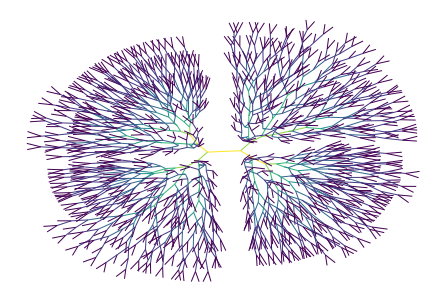

In [22]:
hs_colors = [min(remapped.node[e[0]]['hs'], remapped.node[e[1]]['hs']) for e in list(remapped.edges)]
print(max(hs_colors), min(hs_colors))

nx.draw_kamada_kawai(nx.Graph(remapped), node_size=0, nodelist=draws, edge_color=hs_colors, node_color='black')
plt.savefig('fractal_bifurcations.png', dpi=2160)

In [23]:
Counter(nx.get_node_attributes(remapped, 'hs').values())

Counter({8: 1, 7: 6, 6: 12, 5: 51, 4: 70, 3: 297, 2: 600, 1: 1038})

In [24]:
Counter(ratios)

Counter({1: 1038, 2: 438, 3: 141, 4: 68, 5: 18, 6: 6, 7: 2, 8: 1})

In [25]:
# vals = Counter(nx.get_node_attributes(remapped, 'hs').values())
vals = Counter(ratios)
bs = [vals[i+1] / vals[i+2] for i in range(len(vals) - 1)]

print(bs)
np.mean(bs), np.std(bs)

[2.3698630136986303, 3.106382978723404, 2.073529411764706, 3.7777777777777777, 3.0, 3.0, 2.0]


(2.761079025994931, 0.5942694626177963)

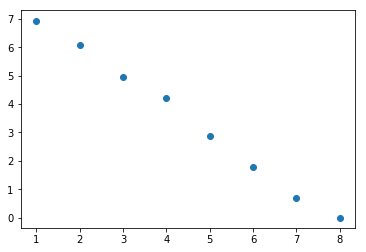

In [26]:
xs = list(Counter(ratios).values())
xs = [np.log(x) for x in xs]

plt.scatter(np.arange(1, len(xs) + 1), xs)

[915.0625, 166.375, 30.25, 5.5, 1.0, 0.18181818181818182, 0.03305785123966942, 0.006010518407212622]
[1038, 438, 141, 68, 18, 6, 2, 1]


[]

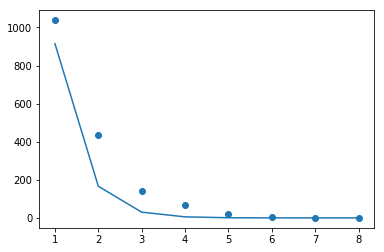

In [27]:
xs = list(Counter(ratios).values())
# xs = [np.log(x) for x in xs]

x2 = np.arange(1, len(vals) + 1)
y2 = [5.5** (5 - x) for x in x2]
print(y2)
print(xs)
# y2 = [v / 5.87 for v in reversed(sorted(vals.values()))]
# y2 = [np.log(y) for y in y2]

plt.scatter(np.arange(1, len(xs) + 1), xs)
plt.plot(x2, y2)
plt.plot()

[ 3.18138387 25.00554986]
0.9887836338336232


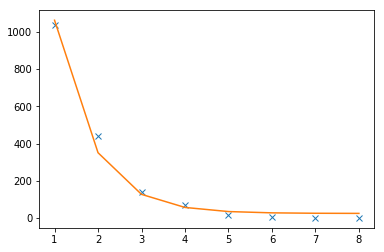

In [30]:
y3 = [np.log(x) for x in xs]
y3 = xs
x3 = np.arange(1, len(vals) + 1)

def hausdorff(x, b, a):
    return a + b ** (7-x)

popt = curve_fit(hausdorff, x3, y3)[0]
print(popt)

# plt.xscale('log')
# plt.yscale('log')
plt.plot(x3, y3, 'x')
curve_vals = [hausdorff(x, *popt) for x in x3]
plt.plot(x3, curve_vals)

y_fit = hausdorff(x3, *popt)

ss_res = np.sum((y3 - y_fit) ** 2)

# total sum of squares
ss_tot = np.sum((y3 - np.mean(y3)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

In [29]:
pickle.dump(levels, open('fractal_levels.pkl', 'wb'))